# QOSF Screening Task 2

Implement a circuit that returns $\left|{01}\right\rangle$ and $\left|{10}\right\rangle$ with equal probability (50% for each).

#### Requirements :

- The circuit should consist only of CNOTs, RXs and RYs.
- Start from all parameters in parametric gates being equal to 0 or randomly chosen.
- Find the right set of parameters using gradient descent.
- Simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise.
- Compare the results for different numbers of measurements: 1, 10, 100, 1000.

# Solution :

 The solution to this problem is divided into various steps, which are as follows:
 
    1. Overview
    2. Circuit & Corresponding Simulations
        a. Basic gate circuit
        b. Required Circuit
    3. Defining Variational Circuit
    4. Noiseless Simulations
    5. Simulations with Noise
    6. Conclusion

## Overview :

Using a universal gate set, to implement a circuit that returns $|01\rangle$ and $|10\rangle$ with equal probability, we use the gates Hadamard, X, CNOT.

- We start from the state $|00\rangle$
- Applying X gate to Qubit 2: $|01\rangle$
- Applying H gate to Qubit 1: $\frac{(|0\rangle + |1\rangle)}{\sqrt{2}}|1\rangle$
- Applying CNOT with control qubit 1 and target qubit 2: $\frac{|01\rangle + |10\rangle}{\sqrt{2}}$
- Hence on measuring this, we would get a circuit that returns $|01\rangle$ and $|10\rangle$ with equal probability $\frac{1}{2}$                                                                                 

#### Now we try to obtain a circuit that returns $|01\rangle$ and $|10\rangle$ with equal probability using Rx, Ry and CNOT gates:

- X gate can be written as Ry($\pi$) gate
- Next part of the circuit has to be an implementation that returns $|0\rangle$ and $|1\rangle$ with equal probability when applied on $|0\rangle$ state. Note that here, it is not necessry to recreate a Hadamard gate, as there can be multiple states with different phases which would returns $|00\rangle$ and $|11\rangle$ with $\frac{1}{2}$ probability.
- Finally we apply a CNOT gate for the result.

For the second part, when applied to $|0\rangle$ state would result in $|0\rangle$ and $|1\rangle$ with equal probability:

- Combination like Ry$(\pi/2)$Rx($\pi/2)$ would result in state $\frac{|00\rangle + |1\rangle}{\sqrt{2}}$
- Combination like Ry$(3\pi/2)$Rx($\pi/2)$ would result in state $\frac{|0\rangle - |1\rangle}{\sqrt{2}}$
- Combination like Ry$(3\pi/2)$Rx($3\pi/2)$ would result in state $\frac{|0\rangle - |1\rangle}{\sqrt{2}}$
- Combination like Ry$(\pi/2)$Rx($3\pi/2)$ would result in state $\frac{|0\rangle + |1\rangle}{\sqrt{2}}$

## Necessary Imports

In [42]:
from qiskit import *
%matplotlib inline
from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import numpy as np

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.device import basic_device_noise_model
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.optimizers.aqgd import AQGD
from qiskit.aqua.components.optimizers.nelder_mead import NELDER_MEAD
import qiskit.providers.aer.noise as noise

## Circuits & Corresponsing Simulations

Here, we are going to make the circuit with basic X,H,CX gate :

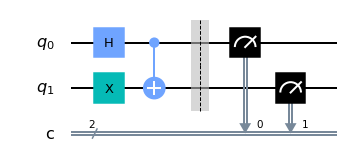

In [2]:
q = QuantumCircuit(2,2)

q.x(1)
q.h(0)
q.cx(0,1)
q.barrier(range(2))
q.measure((0,1),(0,1))

q.draw('mpl')

{'01': 494, '10': 530}


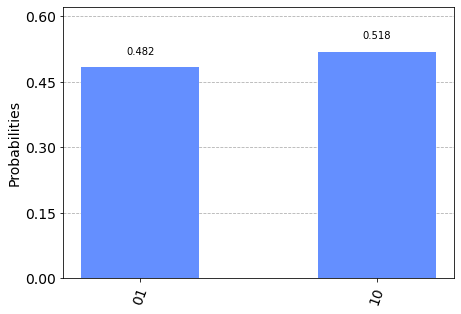

In [3]:
backend = Aer.get_backend('qasm_simulator')
job = execute(q, backend, shots= 1024)
result = job.result()
count = result.get_counts()
print(count)
plot_histogram(count)

[0.+0.j 1.+0.j 0.+0.j 0.+0.j]


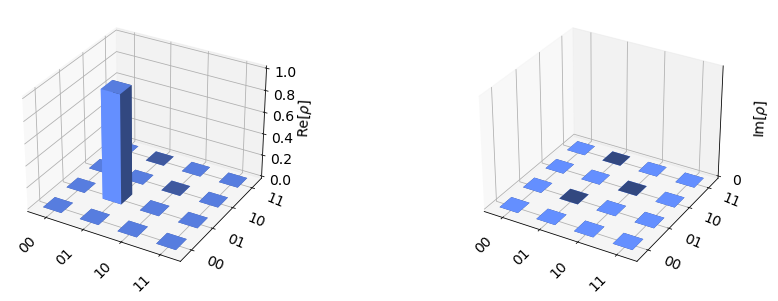

In [4]:
backend = Aer.get_backend('statevector_simulator')
job = execute(q, backend)
result = job.result()
state = result.get_statevector(q, decimals=3)
print(state)
plot_state_city(state)

Now, we will make a circuit by using only Rx, Ry & CX gate :

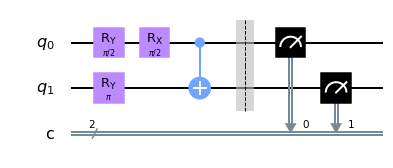

In [5]:
q = QuantumCircuit(2,2)

# qc.rx(np.pi,0
q.ry((np.pi/2),0)
q.ry(np.pi,1)
q.rx((np.pi/2),0)
q.cx(0,1)
q.barrier(range(2))
q.measure((0,1),(0,1))

q.draw('mpl')

{'01': 524, '10': 500}


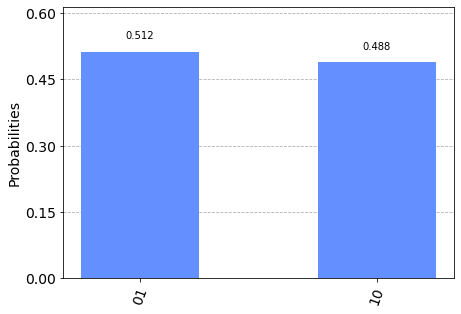

In [6]:
backend = Aer.get_backend('qasm_simulator')
job = execute(q, backend, shots= 1024)
result = job.result()
count = result.get_counts()
print(count)
plot_histogram(count)

[0.+0.j 0.+0.j 1.+0.j 0.+0.j]


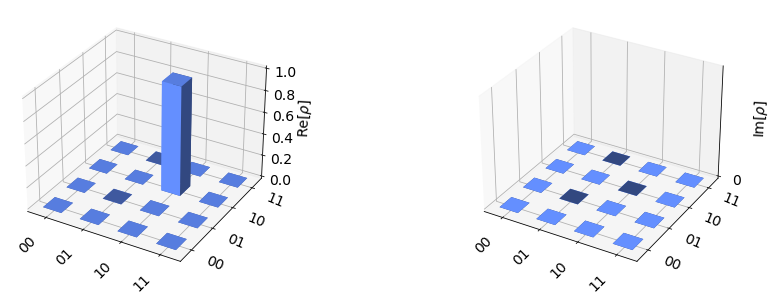

In [7]:
backend = Aer.get_backend('statevector_simulator')
job = execute(q, backend)
result = job.result()
state = result.get_statevector(q, decimals=3)
print(state)
plot_state_city(state)

as we can see that both results are in good match. So, Let us proced with the next step 

### But we have to find the right set of parameters being equal to 0 or randomly chosen using gradient descent.

#### Also, simulations must be done with sampling and noise.

At first, we need to write the functions for creating the circuit and measuring the outcomes. Then we can get the probabilities from the results. We will then calculate the cost by putting all of it together and then apply optimizer to the cost function in order to find the proper parameters.

In [8]:
def circuit(params):
    
    circ = QuantumCircuit(2,2)
    
    circ.ry(params[0],0)
    circ.ry(params[1],1)
    circ.rx(params[2],0)
    circ.cx(0,1)
    circ.barrier(range(2))
    circ.measure((0,1),(0,1))
    
    return circ

In [9]:
def counts( circ, shot):
    
    # defining backend 
    backend = Aer.get_backend('qasm_simulator')
    
    # adding noise
    noise_model = noise.NoiseModel()
    
    job = execute(circ, backend, shots=shot, noise_model=noise_model)
    result = job.result()
    count = result.get_counts()
    
        
    return count

In [10]:
# getting probabilities for each of 00, 01, 10, 11 

def probabilities(count,shots):
    
    p00 = 0
    p01 = 0
    p10 = 0
    p11 = 0
    
    if '00' in count.keys():
        p00 = count['00']/shots*100
    
    if '01' in count.keys():
        p01 = count['01']/shots*100
    
    if '10' in count.keys():
        p10 = count['10']/shots*100
            
    if '11' in count.keys():
        p11 = count['11']/shots*100
    
        
    costs = ((0-p00)**2 + (50-p01)**2 + (50-p10)**2 + (0-p11)**2)
        
        
    return costs

In [11]:
# putting all of it together and computing cost of the circuit for certain shots

class compute_cost:
    
    def cost(self, params):

        cir = circuit(params)

        count = counts(cir,self.shot)

        costs = probabilities(count,self.shot)

        return costs

# Comparing different optimizers

## Noiseless simulation

The optimization done above was using basic gradient descent. There are many more advanced optimization algorithm that can make the variational parameters converge faster. Lets now compare the convergence of some different optimizers. For this the number of shots per measurements will be kept fixed.

    1. Analytic Quantum Gradient Descent optimizer (AQGD)
    2. Nelder-Mead Optimizer

## Analytic Quantum Gradient Descent optimizer (AQGD)

In [12]:
optimizer1 = AQGD(maxiter=5000, eta=1.0, tol=1e-03, disp=False, momentum=0.30)

#sampling
shots=[1,10,100,1000]

step_no = 100

min_aqgd_costs = []

for shot_no in shots:
    cost_obj = compute_cost()
    cost_obj.shot = shot_no
    
    print('Shot no: ',shot_no)
    
    aqgd_optimizer_costs = []
    minimum_cost = 1000000.0
    minimum_param = []
        
    for i in range(step_no):  
        init = np.random.rand(3)
        param = optimizer1.optimize(num_vars=3, objective_function=cost_obj.cost, initial_point=init)
        if (i+1)%20 ==0 and i:
            print('parameters: ',param[0],'cost: ',param[1],' after ',i+1,' iterations')
        aqgd_optimizer_costs.append(param)
        if param[1] <= 1.00:
            break
    
    
    for par in aqgd_optimizer_costs:
        if par[1] < minimum_cost:
            minimum_cost = par[1]
            minimum_param = list(par[0])
            
    min_aqgd_costs.append(minimum_param)

Shot no:  1
parameters:  [0.07551809 0.5542182  0.99410713] cost:  15000.0  after  20  iterations
parameters:  [0.66841359 0.25065973 0.13646216] cost:  15000.0  after  40  iterations
parameters:  [0.13692156 0.47703136 0.99215517] cost:  15000.0  after  60  iterations
parameters:  [-9998.92372574  9733.49857732  3500.54740608] cost:  5000.0  after  80  iterations
parameters:  [0.18029502 0.7868456  0.7297458 ] cost:  5000.0  after  100  iterations
Shot no:  10
Shot no:  100
Shot no:  1000


In [13]:
print(min_aqgd_costs)

[[1496.58672738849, 14464.285395582952, 9996.11313279734], [15897.394378237106, 360701.38331578404, 60790.30324225577], [-15411.346699293488, 128478.39172089694, -26827.11545050948], [8249.16418761827, 161063.30686421396, 1274.1997660880345]]


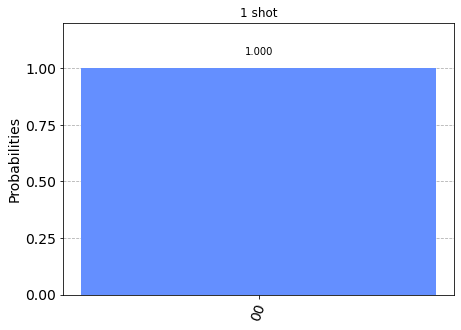

In [14]:
#  1 shot
circuit_1 = circuit(min_aqgd_costs[0])
counted_1 = counts(circuit_1, 1)
plot_histogram(counted_1, title="1 shot")

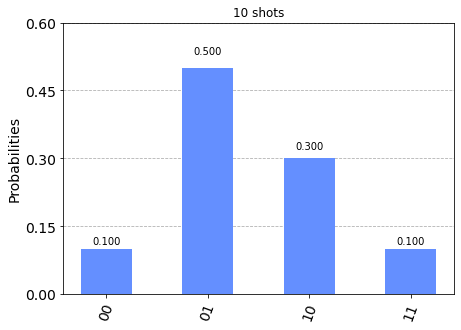

In [15]:
#  10 shots
circuit_10 = circuit(min_aqgd_costs[1])
counted_10 = counts(circuit_10, 10)
plot_histogram(counted_10, title="10 shots")

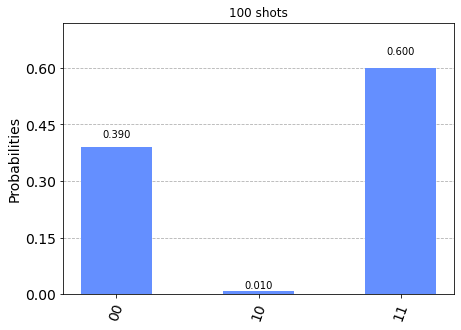

In [16]:
#  100 shots
circuit_100 = circuit(min_aqgd_costs[2])
counted_100 = counts(circuit_100, 100)
plot_histogram(counted_100, title="100 shots")

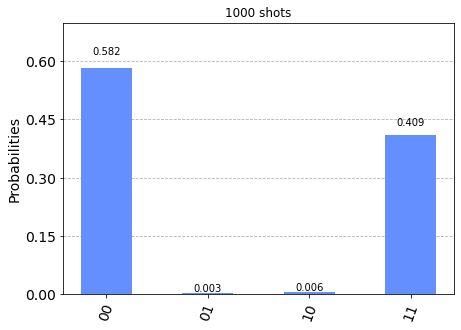

In [17]:
#  1000 shots
circuit_1000 = circuit(min_aqgd_costs[3])
counted_1000 = counts(circuit_1000, 1000)
plot_histogram(counted_1000, title="1000 shots")

## Nelder-Mead Optimizer 

In [18]:
optimizer2 = NELDER_MEAD(maxfev=1000, disp=False, xatol=0.05, tol=0.05 )

# sampling
shots=[1,10,100,1000]

step_no = 120

min_nelder_mead_costs = []

for shot_no in shots:
    cost_obj = compute_cost()
    cost_obj.shot = shot_no
    
    print('Shot no: ',shot_no)
    
    nelder_mead_optimizer_costs = []
    minimum_cost = 1000000.0
    minimum_param = []
        
    for i in range(step_no):  
        init = np.random.rand(3)
        param = optimizer2.optimize(num_vars=3, objective_function=cost_obj.cost, initial_point=init)
        if (i+1)%20 ==0 and i:
            print('parameters: ',param[0],'cost: ',param[1],' after ',i+1,' iterations')
        nelder_mead_optimizer_costs.append(param)
        if param[1] <= 1.00:
            break
    
    
    for par in nelder_mead_optimizer_costs:
        if par[1] < minimum_cost:
            minimum_cost = par[1]
            minimum_param = list(par[0])
            
    min_nelder_mead_costs.append(minimum_param)

Shot no:  1
parameters:  [0.01844492 0.97438155 0.62231614] cost:  5000.0  after  20  iterations
parameters:  [0.33170061 0.08487143 0.24056826] cost:  15000.0  after  40  iterations
parameters:  [0.36007763 0.07461205 0.56404474] cost:  15000.0  after  60  iterations
parameters:  [0.74259435 0.97748888 0.91916297] cost:  5000.0  after  80  iterations
parameters:  [0.93259283 0.35050734 0.8239155 ] cost:  15000.0  after  100  iterations
parameters:  [0.42813999 0.57885541 0.11146255] cost:  15000.0  after  120  iterations
Shot no:  10
parameters:  [0.34735546 0.35239197 0.21371522] cost:  6200.0  after  20  iterations
parameters:  [0.65253304 0.60860803 0.4974889 ] cost:  3800.0  after  40  iterations
parameters:  [0.01947525 0.6988971  0.63651166] cost:  3000.0  after  60  iterations
parameters:  [0.7195722  0.04288066 0.18520555] cost:  9400.0  after  80  iterations
parameters:  [0.0648529  0.44420073 0.62595462] cost:  4600.0  after  100  iterations
parameters:  [0.34078983 0.112146

In [19]:
print(min_nelder_mead_costs)

[[0.5757569586673631, 0.8337491547642202, 0.28666122951640227], [0.45943189840284515, 0.9837884239678532, 0.17834872227290066], [0.9448542842444441, 0.9916467150781676, 0.823286014871494], [1.5805009916299009, 3.2322949780620767, -0.31707138779344957]]


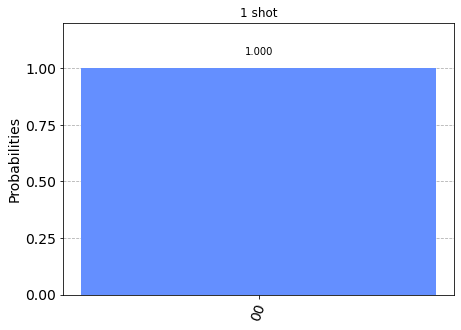

In [20]:
#  1 shot
circuit_1 = circuit(min_nelder_mead_costs[0])
counted_1 = counts(circuit_1, 1)
plot_histogram(counted_1, title = "1 shot")

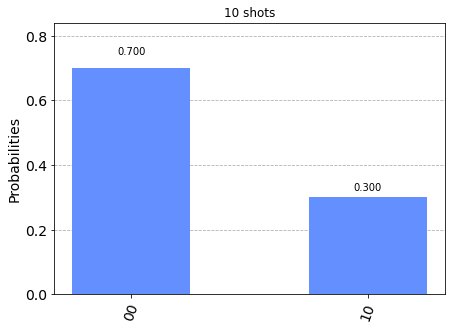

In [21]:
#  10 shots
circuit_10 = circuit(min_nelder_mead_costs[1])
counted_10 = counts(circuit_10, 10)
plot_histogram(counted_10, title="10 shots")

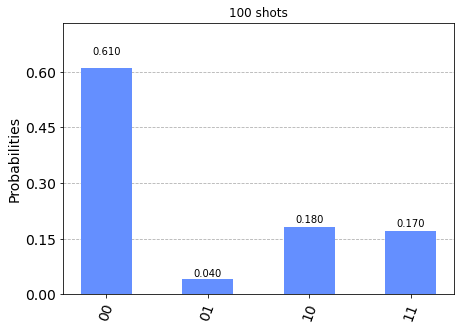

In [22]:
#  100 shots
circuit_100 = circuit(min_nelder_mead_costs[2])
counted_100 = counts(circuit_100, 100)
plot_histogram(counted_100, title="100 shots")

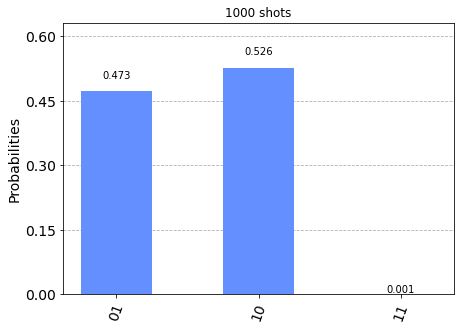

In [23]:
#  1000 shots
circuit_1000 = circuit(min_nelder_mead_costs[3])
counted_1000 = counts(circuit_1000, 1000)
plot_histogram(counted_1000, title="1000 shots")


## Simulation in Real Device with Noise 

We generate a noise model for our simulator from the properties of a real quantum device 'ibmq_vigo' and run the COBYLA optimizer to get the parameters for our circuit.

In [24]:
from qiskit.aqua.components.optimizers import COBYLA

In [25]:
provider=IBMQ.load_account() # Load account from disk
backend_real = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(backend_real)
coupling_map = backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

C:\ProgramData\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [26]:
optimizer2 = COBYLA(maxiter=1000, disp=False, tol=0.05)

# sampling
shots=[1,10,100,1000]
step_no = 120

min_COBYLA_costs = []

for shot_no in shots:
    cost_obj = compute_cost()
    cost_obj.shot = shot_no
    
    print('Shot no: ',shot_no)
    
    COBYLA_optimizer_costs = []
    minimum_cost = 1000000.0
    minimum_param = []
        
    for i in range(step_no):  
        init = np.random.rand(3)
        param = optimizer2.optimize(num_vars=3, objective_function=cost_obj.cost, initial_point=init)
        if (i+1)%20 ==0 and i:
            print('parameters: ',param[0],'cost: ',param[1],' after ',i+1,' iterations')
        COBYLA_optimizer_costs.append(param)
        if param[1] <= 1.00:
            break
    
    
    for par in COBYLA_optimizer_costs:
        if par[1] < minimum_cost:
            minimum_cost = par[1]
            minimum_param = list(par[0])
            
    min_COBYLA_costs.append(minimum_param)

Shot no:  1
parameters:  [0.76013121 1.11791458 0.73591679] cost:  15000.0  after  20  iterations
parameters:  [0.24743029 0.59559354 0.11196612] cost:  15000.0  after  40  iterations
parameters:  [1.90651871 0.84723894 0.64178173] cost:  15000.0  after  60  iterations
parameters:  [0.75257547 1.34387319 0.68852513] cost:  5000.0  after  80  iterations
parameters:  [0.50371177 0.65169211 1.52795389] cost:  15000.0  after  100  iterations
parameters:  [0.79235036 1.80265174 0.2864192 ] cost:  5000.0  after  120  iterations
Shot no:  10
Shot no:  100
parameters:  [1.52352058 3.30719734 2.02452954] cost:  162.0  after  20  iterations
Shot no:  1000


In [27]:
print(min_COBYLA_costs)

[[0.07989905671476802, 1.3564706945085039, 0.3333280435921848], [1.3129862955755056, 2.7046439625579417, 1.608940271351383], [0.8116199783544222, 3.320425998753295, 1.7016793010020388], [1.7731730586460157, 3.2508186139353605, 1.613797706199202]]


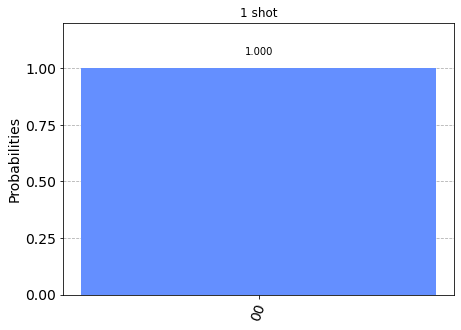

In [28]:
#  1 shot
circuit_1 = circuit(min_COBYLA_costs[0])
counted_1 = counts(circuit_1, 1)
plot_histogram(counted_1, title="1 shot")

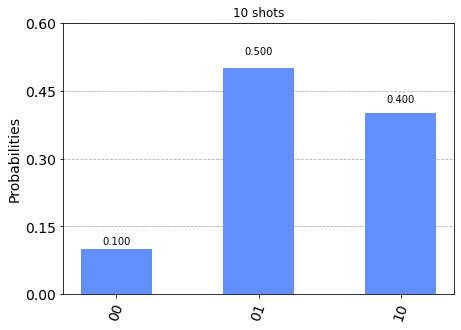

In [35]:
#  10 shots
circuit_10 = circuit(min_COBYLA_costs[1])
counted_10 = counts(circuit_10, 10)
plot_histogram(counted_10, title="10 shots")

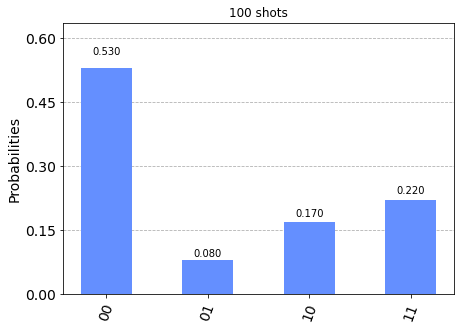

In [40]:
#  100 shots
circuit_100 = circuit(min_nelder_mead_costs[2])
counted_100 = counts(circuit_100, 100)
plot_histogram(counted_100, title="100 shots")

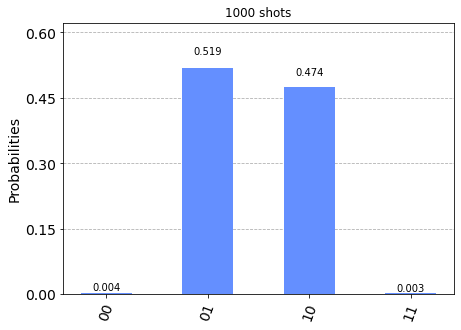

In [31]:
#  10 shots
circuit_1000 = circuit(min_nelder_mead_costs[3])
counted_1000 = counts(circuit_1000, 1000)
plot_histogram(counted_1000, title="1000 shots")


# Conclusion :

The more the number of measurements we make, closer the results be to reality.


### Note :  There is a separate notebook for Bonus Question.